In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from matplotlib.lines import Line2D
from metrics import get_jsd, get_probkappa_mcqs, get_kappa_mcqs, get_diffp, populate_preds, precomputed_accs, precomputed_diffs

/is/sg2/sgoel/miniconda3/envs/diff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preds_dict = {}
folder_name = "epochs_3"
model_names = ["weak_ft", "strong_base2", "w2s", "strong2"]
skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B"), ("Qwen2.5-0.5B", "OLMo-2-1124-7B"), ("Qwen2.5-0.5B", "Qwen2.5-14B"), ("Qwen2.5-0.5B", "gemma-2-27b"), ("Qwen2.5-0.5B", "granite-3.0-8b-base"), ("gemma-2-2b", "OLMo-2-1124-7B"), ("SmolLM-1.7B", "gemma-2-9b"), ("SmolLM-1.7B", "Qwen2.5-7B"), ("SmolLM-1.7B", "Llama-3.1-8B")]
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "sciq", "sst2", "twitter-sentiment", "dream", "mc_taco", "multirc", "quail", "quartz", "social_i_qa", "wic", "cosmos_qa"]

#iterate over folder names with ___ in results/{folder_name}
for dir in os.listdir(f"results/{folder_name}"):
    dir_path = f"results/{folder_name}/{dir}"
    if os.path.isdir(dir_path) and "___" in dir:
        weak_model, strong_model = dir.split("___")
        if (weak_model, strong_model) in skip_list:
            continue
        print(f"Models: {weak_model}, {strong_model}")
        # datasets = os.listdir(dir_path)
        # datasets = [d for d in datasets if d != "plots"]
        datasplits = ["val", "test"]
        preds = {}
        preds = populate_preds(preds, datasets, model_names, datasplits, folder_name, weak_model, strong_model)
        preds_dict[(weak_model, strong_model)] = preds        


Models: Qwen2.5-0.5B, Llama-3.1-8B


Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


In [3]:
# Updated loop to handle legend-based R^2 values
# skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B"), ("Qwen2.5-0.5B", "OLMo-2-1124-7B"), ("Qwen2.5-0.5B", "Qwen2.5-14B"), ("Qwen2.5-0.5B", "gemma-2-27b"), ("Qwen2.5-0.5B", "granite-3.0-8b-base"), ("gemma-2-2b", "OLMo-2-1124-7B")]
diffs_test = {}
diffmodw = "weak_ft"
diffmods = "strong_base2"
diff_split = "val"

for metric_func, metric_name in zip([get_jsd, get_probkappa_mcqs, get_kappa_mcqs, get_diffp, _, _], ["JSD", "ProbKappa", "Kappa", "Prediction Diff%", "Accuracy Gap", "Mag Accuracy Gap"]):
    diffs_test[metric_name] = {}
    for (weak_model, strong_model), preds in preds_dict.items():
        if (weak_model, strong_model) in skip_list:
            continue
        if "Accuracy Gap" in metric_name:
            acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
            acc_val = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, diff_split) for dset in datasets}
            diffs_test[metric_name][(weak_model, strong_model)] = {dset: acc_val[dset][diffmods] - acc_val[dset][diffmodw] for dset in datasets}
            if "Mag" in metric_name:
                diffs_test[metric_name][(weak_model, strong_model)] = {dset: np.abs(v) for dset, v in diffs_test[metric_name][(weak_model, strong_model)].items()}
            continue
        print(weak_model, strong_model)
        diffs_test[metric_name][(weak_model, strong_model)] = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, diff_split, metric_func, metric_name, diffmodw, diffmods) for dset in datasets}

Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B


Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-7B
phi-2 Qwen2.5-7B
Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B
Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-7B
phi-2 Qwen2.5-7B
Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B
Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-7B
phi-2 Qwen2.5-7B
Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B
Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-7B
phi-2 Qwen2.5-7B


In [14]:
# Example model short form dictionary
model_short_form = {
    "Llama-3.1-8B": "L.1-8",
    "gemma-2-9b": "G-9",
    "phi-2": "P-2.7",
    "gemma-2-2b": "G-2",
    "Qwen2.5-7B": "Q-7",
    "Llama-3.2-1B": "L.2-1",
    "Qwen2.5-0.5B": "Q-0.5",
    "SmolLM-1.7B": "S-1.7",
    # Add more models as needed
}

# Define the metrics you want to compute
metrics = {
    "JSD": get_jsd,
    "ProbKappa": get_probkappa_mcqs,
    "Kappa": get_kappa_mcqs,
    "Prediction Diff%": get_diffp
}

# The base DataFrame columns you requested
base_columns = [
    "WeakModel", "StrongModel", "Dataset",
    "StrongBaseAcc", "WeakFtAcc", "W2SAcc", "StrongFtAcc",
    "JSD", "ProbKappa", "Kappa", "DiffP", "MagGap", "AccGap"
]

data_records = []

In [15]:
# Build the unified DataFrame
for (weak_model, strong_model), preds in preds_dict.items():
    if (weak_model, strong_model) in skip_list:
        continue
    
    print(f"Processing Models: {weak_model}, {strong_model}")
    
    # Compute accuracy dict for each dataset
    acc_test = {
        dset: precomputed_accs(
            preds,
            f"{folder_name}/{weak_model}___{strong_model}",
            dset,
            model_names,
            "test"
        )
        for dset in datasets
    }
    
    # Compute metric values for each dataset
    # Assuming diffs_test is structured as: diffs_test[metric_name][(weak_model, strong_model)][dset]
    for dset in datasets:
        # Extract required accuracies
        strong_base_acc = acc_test[dset]["strong_base2"]
        weak_ft_acc = acc_test[dset]["weak_ft"]
        w2s_acc = acc_test[dset]["w2s"]
        strong_ft_acc = acc_test[dset]["strong2"]
        
        # Compute metrics
        # Make sure these metric functions accept the appropriate parameters.
        # Typically, they might need predictions or something similar.
        # Adjust the calls as needed based on how get_jsd, get_kappa_mcqs, get_diffp are defined.
        jsd_value = diffs_test["JSD"][(weak_model, strong_model)][dset]   # Example usage
        probkappa_value = diffs_test["ProbKappa"][(weak_model, strong_model)][dset]
        kappa_value = diffs_test["Kappa"][(weak_model, strong_model)][dset]
        diffp_value = diffs_test["Prediction Diff%"][(weak_model, strong_model)][dset]
        maggap_value = diffs_test["Mag Accuracy Gap"][(weak_model, strong_model)][dset]
        accgap_value = diffs_test["Accuracy Gap"][(weak_model, strong_model)][dset]
        
        record = {
            "WeakModel": weak_model,
            "StrongModel": strong_model,
            "Dataset": dset,
            "StrongBaseAcc": strong_base_acc,
            "WeakFtAcc": weak_ft_acc,
            "W2SAcc": w2s_acc,
            "StrongFtAcc": strong_ft_acc,
            "JSD": jsd_value,
            "ProbKappa": probkappa_value,
            "Kappa": kappa_value,
            "DiffP": diffp_value,
            "MagGap": maggap_value,
            "AccGap": accgap_value
        }
        data_records.append(record)

df_base = pd.DataFrame(data_records, columns=base_columns)

# Now df_base is your unified DataFrame with all the requested base columns.
print(df_base.head())

Processing Models: Qwen2.5-0.5B, Llama-3.1-8B
Processing Models: gemma-2-2b, Llama-3.1-8B
Processing Models: Qwen2.5-0.5B, gemma-2-9b
Processing Models: Llama-3.2-1B, Llama-3.1-8B
Processing Models: phi-2, Llama-3.1-8B
Processing Models: Llama-3.2-1B, Qwen2.5-7B
Processing Models: Llama-3.2-1B, gemma-2-9b
Processing Models: Qwen2.5-0.5B, Qwen2.5-7B
Processing Models: gemma-2-2b, gemma-2-9b


Processing Models: phi-2, gemma-2-9b
Processing Models: gemma-2-2b, Qwen2.5-7B
Processing Models: phi-2, Qwen2.5-7B
      WeakModel   StrongModel                Dataset  StrongBaseAcc  \
0  Qwen2.5-0.5B  Llama-3.1-8B                anli-r2      53.293413   
1  Qwen2.5-0.5B  Llama-3.1-8B                  boolq      66.531932   
2  Qwen2.5-0.5B  Llama-3.1-8B                   cola      72.204969   
3  Qwen2.5-0.5B  Llama-3.1-8B  ethics-utilitarianism      61.953913   
4  Qwen2.5-0.5B  Llama-3.1-8B                   sciq      84.932886   

   WeakFtAcc     W2SAcc  StrongFtAcc       JSD  ProbKappa     Kappa  DiffP  \
0  57.934132  63.023952    72.305389  0.397371   0.041858  0.172070  0.322   
1  77.081649  83.346807    87.631366  0.316652   0.057493  0.220265  0.316   
2  77.018634  80.900621    80.590062  0.287032   0.106297  0.269438  0.277   
3  54.944791  67.858857    79.788766  0.284669   0.035086  0.170282  0.306   
4  83.657718  87.919463    92.718121  0.318784   0.174308  0.267397

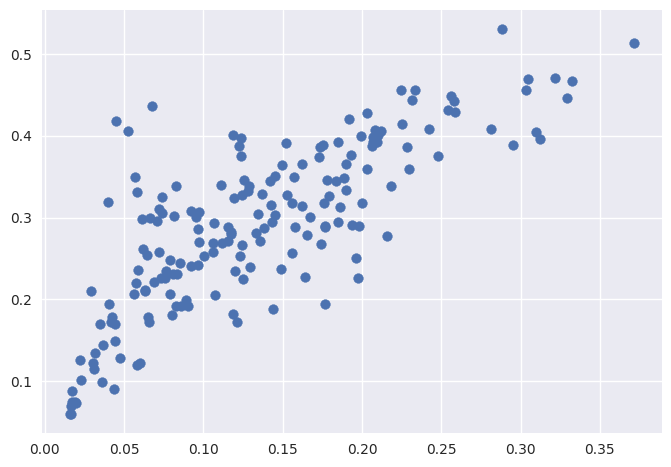

In [16]:
plt.scatter(df_base["ProbKappa"], df_base["Kappa"])

In [17]:
#sort df_base by ProbKappa - Kappa and print
df_base["Kappa - ProbKappa"] = -(df_base["ProbKappa"] - df_base["Kappa"])
df_base = df_base.sort_values(by="Kappa - ProbKappa", ascending=False)
print(df_base)

        WeakModel   StrongModel                Dataset  StrongBaseAcc  \
11   Qwen2.5-0.5B  Llama-3.1-8B                 quartz      58.769634   
73          phi-2  Llama-3.1-8B                    wic      64.890282   
41   Qwen2.5-0.5B    gemma-2-9b                 quartz      68.455497   
58   Llama-3.2-1B  Llama-3.1-8B                    wic      64.890282   
178         phi-2    Qwen2.5-7B                    wic      64.106583   
..            ...           ...                    ...            ...   
15     gemma-2-2b  Llama-3.1-8B                anli-r2      53.293413   
112  Qwen2.5-0.5B    Qwen2.5-7B                  dream      84.627016   
123    gemma-2-2b    gemma-2-9b  ethics-utilitarianism      59.433509   
34   Qwen2.5-0.5B    gemma-2-9b                   sciq      89.899329   
109  Qwen2.5-0.5B    Qwen2.5-7B                   sciq      88.120805   

     WeakFtAcc     W2SAcc  StrongFtAcc       JSD  ProbKappa     Kappa  DiffP  \
11   58.638743  63.481675    86.387435  0.1

In [37]:


def plot_scatter(df, 
                 x_col, 
                 y_col, 
                 r_cols=None, 
                 groupby=None, 
                 hue_col="Dataset", 
                 annotate_modelpairs=False, 
                 model_short_form=None, 
                 title=None,
                 add_scatter=True  
                ):
    """
    Plot scatter of x_col vs. y_col with optional linear regression lines.
    If 'Group' is used as hue_col, color encodes the weak model and both linestyle + marker encode the strong model.
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to be plotted.
    x_col : str
        Column name for the x-axis.
    y_col : str
        Column name for the y-axis.
    r_cols : list, optional
        Columns to be used as predictors for computing residuals (optional).
    groupby : str, optional
        If provided, groups data for analysis (unused directly here).
    hue_col : str, default='Dataset'
        Column to use for coloring or grouping lines/points.
        If hue_col = 'Group', color represents the weak model, and line style + marker represent the strong model.
    annotate_modelpairs : bool, optional
        Unused in this version.
    model_short_form : dict, optional
        Unused in this version.
    title : str, optional
        Plot title.
    add_scatter : bool, default=True
        If True, scatter points are plotted; if False, they are omitted.
    """
    plt.figure(figsize=(8, 8))
    plt.style.use('seaborn-v0_8')
    
    # Add regression lines & R²
    r2_dict = {}
    sum_r2_sign = 0
    
    # =============== CASE 1: hue_col == 'Group' (Weak/Strong Models) ===============
    if hue_col == 'Group':
        # Split 'Group' into Weak/Strong model names
        df['WeakModel_Name'] = df['Group'].apply(lambda x: x.split('_')[0])
        df['StrongModel_Name'] = df['Group'].apply(lambda x: '_'.join(x.split('_')[1:]))
        
        # Create unique color and linestyle mappings for WEAK/STRONG
        weak_models = sorted(df['WeakModel_Name'].unique())
        strong_models = sorted(df['StrongModel_Name'].unique())
        
        # ============ COLOR for Weak Models ============
        weak_colors = sns.color_palette("husl", n_colors=len(weak_models))
        weak_color_map = dict(zip(weak_models, weak_colors))
        
        # ============ LINESTYLE for Strong Models ============
        linestyles = ['-', '--', '-.', ':'] * (len(strong_models) // 4 + 1)
        strong_style_map = dict(zip(strong_models, linestyles[:len(strong_models)]))
        
        # ============ MARKER SHAPE for Strong Models ============
        # Adjust or add more markers if you have more strong models
        marker_styles = ['o', 's', 'd', '^', 'v'] * (len(strong_models) // 5 + 1)
        strong_marker_map = dict(zip(strong_models, marker_styles[:len(strong_models)]))
        
        # We will store all data for plotting
        group_data = []
        
        # Go through each group
        for label in df[hue_col].unique():
            label_df = df[df[hue_col] == label].copy()
            if len(label_df) < 2:
                continue
            
            # If r_cols given, compute and store residual
            if r_cols is not None:
                X_for_resid = label_df[r_cols]
                y_for_resid = label_df[y_col]
                reg_resid = LinearRegression().fit(X_for_resid, y_for_resid)
                label_df['Residual'] = y_for_resid - reg_resid.predict(X_for_resid)
            
            # Fit regression line on x_col vs. y_col (or residual)
            X = label_df[x_col].values.reshape(-1, 1)
            Y = label_df[y_col].values if r_cols is None else label_df['Residual'].values
            reg = LinearRegression().fit(X, Y)
            r2 = reg.score(X, Y)
            
            # Determine correlation sign
            correlation = ('Positive' if reg.coef_[0] > 0 
                           else 'Negative' if reg.coef_[0] < 0 
                           else 'Zero')
            r2_dict[label] = f"{correlation} (R²={r2:.2f})"
            
            # Get color & linestyle & marker from weak/strong model
            weak_model = label.split('_')[0]
            strong_model = '_'.join(label.split('_')[1:])
            color = weak_color_map[weak_model]
            linestyle = strong_style_map[strong_model]
            marker = strong_marker_map[strong_model]
            
            # Accumulate for plotting
            group_data.append((strong_model, weak_model, label, color, linestyle, marker, reg, X, label_df))
            
            # Track sum for average R² sign
            sum_r2_sign += (1 if reg.coef_[0] > 0 else -1) * r2
        
        # Sort group data by (StrongModel, WeakModel) so lines are drawn in a consistent order
        group_data.sort(key=lambda x: (x[0], x[1]))
        
        # -- PLOTTING: Regressions first --
        for (strong_model, weak_model, label, color, linestyle, marker, reg, X, label_df) in group_data:
            x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
            y_pred = reg.predict(x_range)
            # The line gets the color from the weak model and style from the strong model
            plt.plot(x_range, y_pred, color=color, linestyle=linestyle, alpha=0.8, linewidth=2)
        
        # -- PLOTTING: Scatter points (optional) --
        if add_scatter:
            for (strong_model, weak_model, label, color, linestyle, marker, reg, X, label_df) in group_data:
                plt.scatter(
                    label_df[x_col], 
                    label_df[y_col] if r_cols is None else label_df['Residual'], 
                    color=color, 
                    alpha=0.8, 
                    edgecolor='w', 
                    linewidth=0.5, 
                    s=100,
                    marker=marker
                )
        
        # Print average R² with sign
        if len(r2_dict) > 0:
            print(f"Average r2: {sum_r2_sign / len(r2_dict)}")
        
        # ------------ CREATE COMPRESSED LEGENDS ------------
        # === Legend 1: Weak models (color only) ===
        weak_legend_lines = []
        for w in weak_models:
            line = Line2D([], [], color=weak_color_map[w], linewidth=4, label=w)
            weak_legend_lines.append(line)
        
        # === Legend 2: Strong models (linestyle + marker) ===
        strong_legend_lines = []
        for s in strong_models:
            line = Line2D([], [], 
                          color='black',        # black or neutral color for demonstration
                          linewidth=2, 
                          linestyle=strong_style_map[s], 
                          marker=strong_marker_map[s],
                          markersize=8,
                          label=s)
            strong_legend_lines.append(line)
        
        # Place legends in the top-right
        # Adjust bbox_to_anchor if you want more fine-grained positioning
        first_legend = plt.legend(
            handles=weak_legend_lines, 
            title='Weak Models (color)', 
            loc='upper right', 
            bbox_to_anchor=(0.97, 1)
        )
        plt.gca().add_artist(first_legend)
        
        second_legend = plt.legend(
            handles=strong_legend_lines, 
            title='Strong Models (line + marker)', 
            loc='upper right', 
            bbox_to_anchor=(1, 0.82)  # slightly lower
        )
        plt.gca().add_artist(second_legend)
    
    # =============== CASE 2: hue_col != 'Group' ===============
    else:
        # Plot a single regression line across df
        if r_cols is not None:
            # Compute residual
            X_for_resid = df[r_cols]
            y_for_resid = df[y_col]
            reg_resid = LinearRegression().fit(X_for_resid, y_for_resid)
            df['Residual'] = y_for_resid - reg_resid.predict(X_for_resid)
        
        sns.regplot(
            data=df, 
            x=x_col, 
            y=(y_col if r_cols is None else 'Residual'), 
            scatter=False, 
            ci=None, 
            line_kws={'linestyle': '--', 'alpha': 0.8, 'linewidth': 2}
        )
        
        # Fit regression for overall R²
        X = df[x_col].values.reshape(-1, 1)
        Y = df[y_col].values if r_cols is None else df['Residual'].values
        reg = LinearRegression().fit(X, Y)
        r2 = reg.score(X, Y)
        correlation = ('Positive' if reg.coef_[0] > 0 else
                       'Negative' if reg.coef_[0] < 0 else 'Zero')
        r2_dict[hue_col] = f"{correlation} (R²={r2:.2f})"
        print(f"{hue_col} overall R² = {r2:.2f}")
        
        # Plot scatter if requested
        if add_scatter:
            sns.scatterplot(
                data=df, 
                x=x_col, 
                y=(y_col if r_cols is None else 'Residual'), 
                hue=hue_col,
                palette='husl', 
                s=100, 
                alpha=0.8,
                edgecolor='w', 
                linewidth=0.5
            )
        
        # Standard Seaborn legend with R² in the label
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels = [
            f"{lab}: {r2_dict.get(lab, '')}" if lab in r2_dict else lab 
            for lab in labels
        ]
        plt.legend(
            handles=handles, 
            labels=new_labels,
            title=f'{hue_col} (with R²)',
            fontsize=16, 
            title_fontsize=18,
            loc='upper right', 
            framealpha=0.9
        )

    # ----- Customize the plot -----
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('Similarity', fontsize=18, fontweight='bold')
    if r_cols is None:
        plt.ylabel('Gain from Weak to Strong Training', fontsize=18, fontweight='bold')
    else:
        plt.ylabel('Residual (Gain - Predicted)', fontsize=18, fontweight='bold')
    
    if title is not None:
        plt.title(title, fontsize=20, fontweight='bold', pad=20)
    else:
        plt.title(f"{y_col} vs. {x_col}", fontsize=20, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

0.3189202157280787


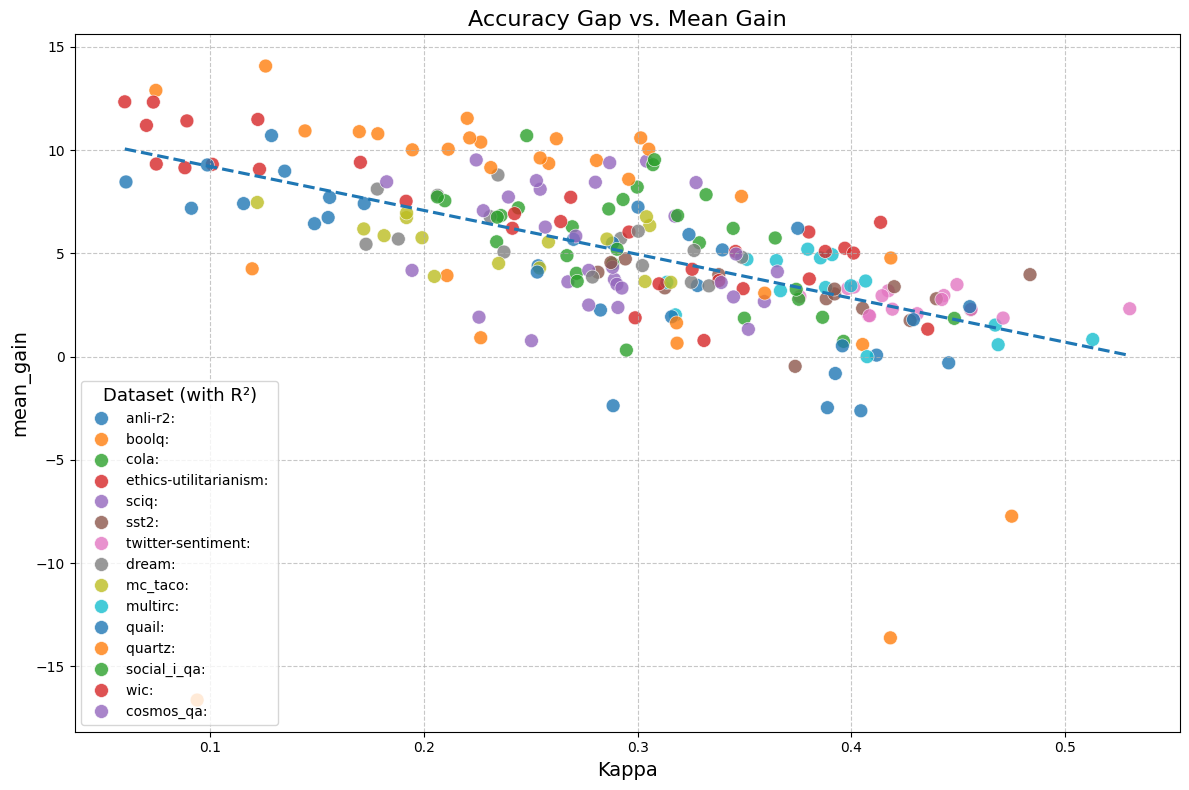

In [7]:
df_base['mean_gain'] = df_base['W2SAcc'] - (df_base['WeakFtAcc'] + df_base['StrongBaseAcc']) / 2
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='mean_gain',
    groupby=False,
    hue_col='Dataset',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Mean Gain"
)

/tmp/ipykernel_2027113/934810258.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_2027113/934810258.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_2027113/934810258.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

Average r2: -0.12069839924527469


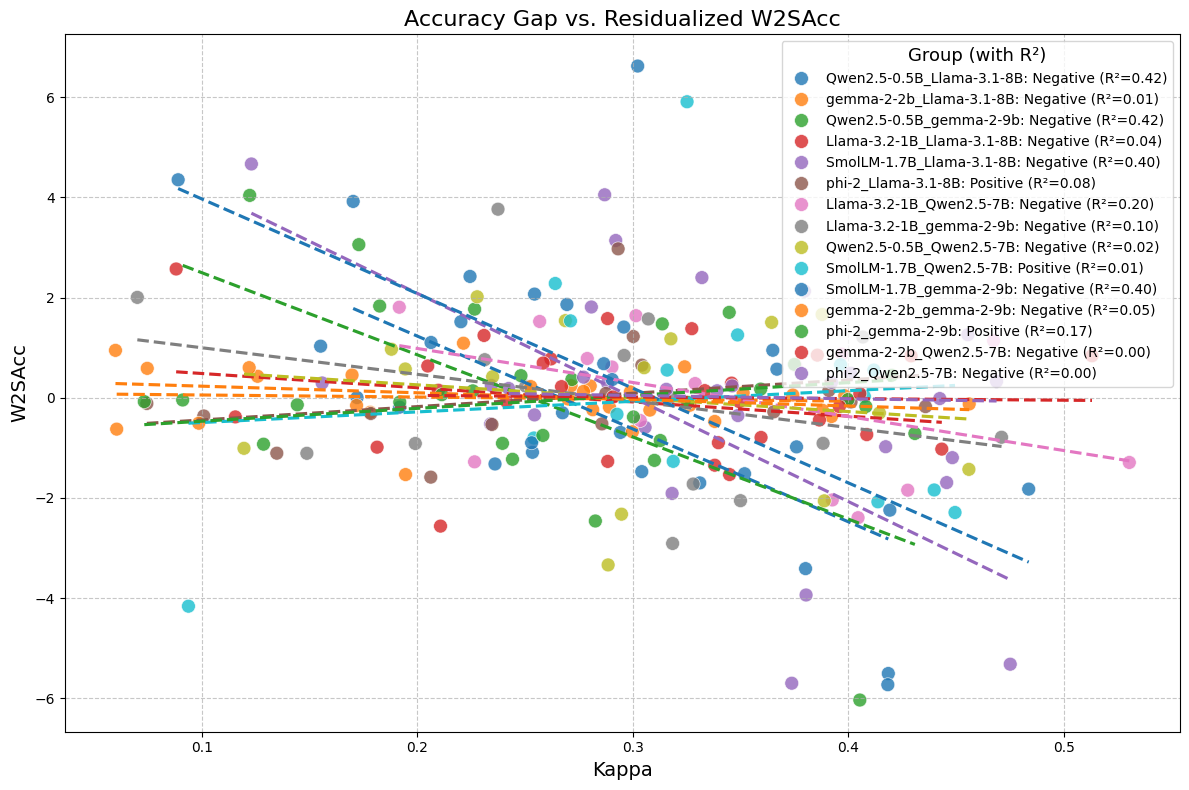

In [8]:
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SAcc',   # <-- use the residuals as y
    r_cols=['WeakFtAcc', 'StrongFtAcc'],  # <-- residuals are computed w.r.t these columns
    groupby=True,
    hue_col='Group',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)

/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

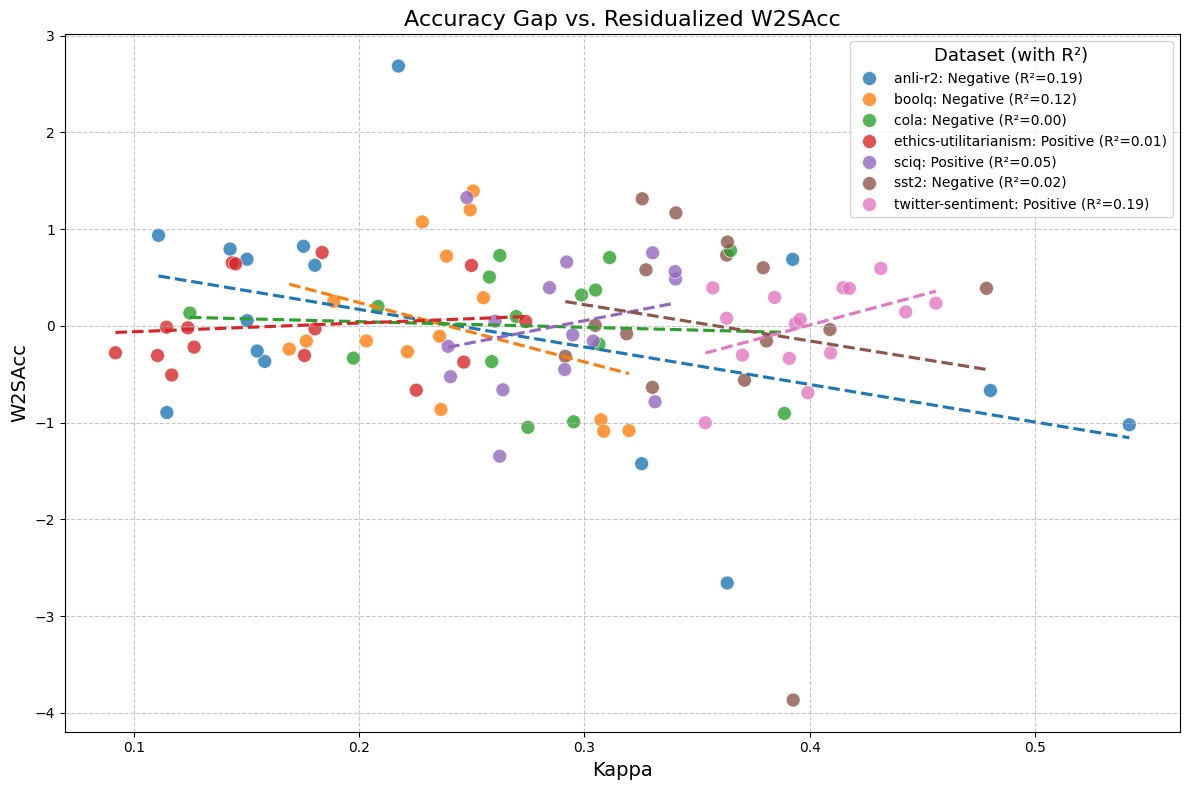

In [46]:
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SAcc',   # <-- use the residuals as y
    r_cols=['WeakFtAcc', 'StrongFtAcc'],  # <-- residuals are computed w.r.t these columns
    groupby=True,
    hue_col='Dataset',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)

Average r2: -0.424565830643525


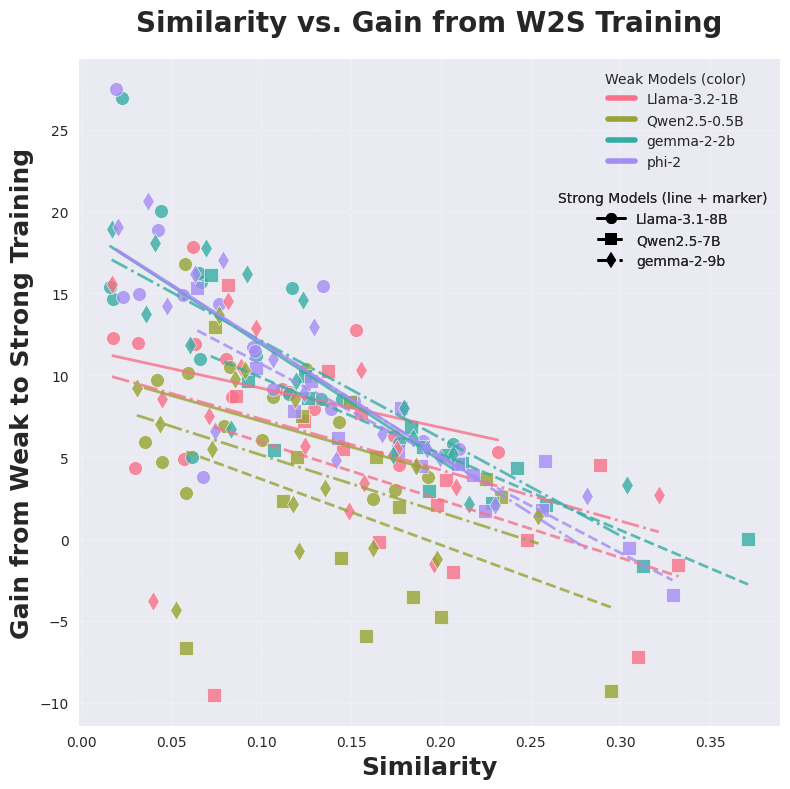

In [38]:
df_base['W2SGain'] = df_base['W2SAcc'] - df_base['StrongBaseAcc']  # dependent variable
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']
x_col_name = 'Similarity'
y_col_name = 'Gain from W2S Training'

# 4. Plot with your existing plot_scatter function
plot_scatter(
    df_base,
    x_col='ProbKappa',
    y_col='W2SGain',   # <-- use the residuals as y
    # r_cols=['AccGap'],
    groupby=True,
    hue_col='Group',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title=f"{x_col_name} vs. {y_col_name}"
)

In [12]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

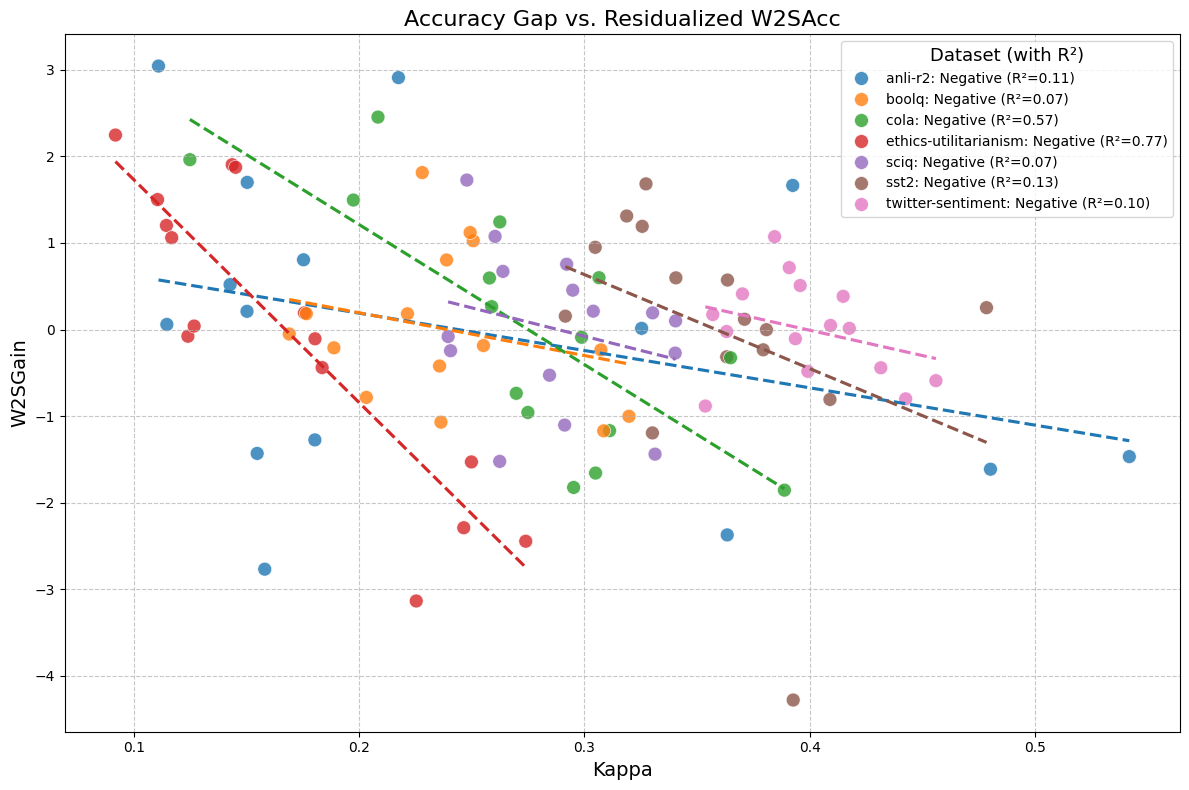

In [47]:
df_base['W2SGain'] = df_base['W2SAcc'] - df_base['WeakFtAcc']  # dependent variable
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']

# 4. Plot with your existing plot_scatter function
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SGain',   # <-- use the residuals as y
    r_cols=['AccGap'],
    groupby=True,
    hue_col='Dataset',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)